# Header

In [1]:
import numpy as np
import abc
import os, sys
import hashlib
from os.path import join as opj

import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import healpy as hp

import plancklens
from plancklens import utils

import lerepi

from component_separation.cs_util import Config

from lerepi.core.visitor import transform
from lerepi.core.transformer.param2dlensalot import p2T_Transformer, transform
from lerepi.visalot import plot_helper as ph
from lerepi.visalot.plot_helper import colorscale, bandpass_alms, get_ms

csu = Config('Planck')
colors = csu.CB_color_cycle
colors_lt = csu.CB_color_cycle_lighter

nside = 2048
lmax_cl = 2048
lmax_plot = 195
lmax_qlm = 2500
lmax_mask = 4096

bk14_edges = np.array([2,55,90,125,160,195,230,265,300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000]) # BK14 is [ 55  90 125 160 195 230 265 300], from bk14 = h5py.File('/global/homes/s/sebibel/notebooks/CMBS4/datasharing/likedata_BK14.mat', 'r')['likedata']['lval'][0,:]
ioreco_edges = np.array([2,30,200, 300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000])
cmbs4_edges = np.array([2, 30, 60, 90, 120, 150, 180, 200, 300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000])

ll = np.arange(0,lmax_plot+1,1)
binspace = 5
scale_uk = (2 * ll + 1) * ll**2 * (ll + 1)**2
scale_ps = ll*(ll+1)/(2*np.pi)
label_scale_ps = r'$\frac{\ell(\ell+1)}{2 \pi}$'
label_scale_lp = r'$\frac{\ell^2(\ell+1)^2}{2 \pi}$'
scale_lp = ll**2 * (ll + 1)**2 * 1e7 / (2 * np.pi)

psl = r'$\frac{l(l+1)}{2\pi}C_\ell \/ [\mu K^2]$'

beam = 2.3
lmax_transf = 4000
transf = hp.gauss_beam(beam / 180. / 60. * np.pi, lmax=lmax_transf)

cls_path = opj(os.path.dirname(plancklens.__file__), 'data', 'cls')
cls_len = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lensedCls.dat'))
clc_templ = cls_len['bb']

MSC: using scarf with 1 OMP threads
could not setup healpix hack. reverting to standard healpy


In [2]:
class parserclass:
    """An abstract element base type for the parser formalism."""
    __metaclass__ = abc.ABCMeta
parser = parserclass()
module_path = os.path.dirname(lerepi.__file__)
parser.resume =  ''
parser.config_file = '/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF20_r10_tol4_cnv065/example_c08d.py'# module_path+'/config/examples/example_c08d.py'
co = parserclass()

In [3]:
def read_data_v2(dm, simids=None, edges=None):
    if simids is not None:
        co.simids = simids
    else:
        co.simids = np.arange(dm.madel.IMIN, dm.madel.IMAX)
    if edges is not None:
        co.edges = cmbs4_edges if edges == 'cmbs4' else ioreco_edges
    else:
        co.edges = cmbs4_edges if co.binid == 'cmbs4' else ioreco_edges
    co.sims = dm.data.package_ + '/' + dm.data.module_
    co.fg = dm.data.class_parameters['fg']
    co.TEMP = transform(dm, p2T_Transformer())
    co.binid = dm.madel.edges
    co.version = dm.analysis.V
    
    co.edges_center = (co.edges[1:]+co.edges[:-1])/2
    co.vers_str = '/{}'.format(co.version) if co.version != '' else ''

    co.ct = clc_templ[np.array(co.edges_center,dtype=int)]
    sha = hashlib.sha256()
    sha.update((str(co.edges)).encode())
    dirid = sha.hexdigest()[:4]
    co.iterations = dm.madel.iterations
    co.nlevels = dm.madel.nlevels
    
    bcl_cs = np.zeros(shape=(len(co.iterations)+2, len(co.nlevels), len(co.simids), len(co.edges)-1))
    bcl_L = np.zeros(shape=(len(co.iterations)+2, len(co.nlevels), len(co.simids), len(co.edges)-1))
    print('Loading {} sims from {}'.format(len(co.simids), co.TEMP + '/plotdata{}/{}'.format(co.vers_str,dirid)))
    for simidx, simid in enumerate(co.simids):
        data = np.load(co.TEMP + '/plotdata{}/{}'.format(co.vers_str,dirid) + '/ClBBwf_sim%04d_fg%2s_res2b3acm.npy'%(simid, co.fg))
        bcl_L[0,:,simidx] = data[0][0]
        bcl_cs[0,:,simidx] = data[1][0]

        bcl_L[1,:,simidx] = data[0][1]
        bcl_cs[1,:,simidx] = data[1][1]

        for iti, it in enumerate(co.iterations):
            bcl_L[2+iti,:,simidx] = data[0][2+iti]
            bcl_cs[2+iti,:,simidx] = data[1][2+iti]

    print('dirid: {}'.format(dirid))
    return bcl_L, bcl_cs

In [4]:
def read_data(dm, simids=None, edges=None, dlm_mod=False):
    if simids is not None:
        co.simids = simids
    else:
        co.simids = np.arange(dm.map_delensing.IMIN, dm.map_delensing.IMAX)
    if edges is not None:
        co.edges = cmbs4_edges if edges == 'cmbs4' else ioreco_edges
    else:
        co.edges = cmbs4_edges if co.binid == 'cmbs4' else ioreco_edges
    co.sims = dm.data.sims
    co.fg = dm.map_delensing.fg
    co.TEMP = transform(dm, p2T_Transformer())
    co.binid = dm.map_delensing.edges
    co.version = dm.iteration.V

    co.edges_center = (co.edges[1:]+co.edges[:-1])/2
    co.vers_str = '/{}'.format(co.version) if co.version != '' else ''

    co.ct = clc_templ[np.array(co.edges_center,dtype=int)]
    sha = hashlib.sha256()
    sha.update((str(co.edges)).encode())
    dirid = sha.hexdigest()[:4]
    co.iterations = dm.map_delensing.ITMAX
    co.nlevels = dm.map_delensing.nlevels
    
    bcl_cs = np.zeros(shape=(len(co.iterations)+2, len(co.nlevels), len(co.simids), len(co.edges)-1))
    bcl_L = np.zeros(shape=(len(co.iterations)+2, len(co.nlevels), len(co.simids), len(co.edges)-1))
    for simidx, simid in enumerate(co.simids):
        if dm.iteration.dlm_mod:
            data = np.load(co.TEMP + '/plotdata{}/{}'.format(co.vers_str,dirid) + '/ClBBwf_sim%04d_dlmmod_fg%2s_res2b3acm.npy'%(simid, co.fg))
        else:
            data = np.load(co.TEMP + '/plotdata{}/{}'.format(co.vers_str,dirid) + '/ClBBwf_sim%04d_fg%2s_res2b3acm.npy'%(simid, co.fg))
        # data =  np.load(dirroot_loc + '{}'.format(dirid) + '/Lenscarf_plotdata_ClBB_sim%04d_fg%2s_res2b3acm.npy'%(simid, fg))
        bcl_L[0,:,simidx] = data[0][0]
        bcl_cs[0,:,simidx] = data[1][0]

        bcl_L[1,:,simidx] = data[0][1]
        bcl_cs[1,:,simidx] = data[1][1]

        for iti, it in enumerate(co.iterations):
            bcl_L[2+iti,:,simidx] = data[0][2+iti]
            bcl_cs[2+iti,:,simidx] = data[1][2+iti]

    print('dirid: {}'.format(dirid))
    return bcl_L, bcl_cs

# Pick data

In [5]:
parser.config_files = [
    '/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF20_r10_tol4_cnv065/example_c08d.py',
    '/global/cscratch1/sd/sebibel/cmbs4/08d_07_OBD_MF20_r10_tol4_cnv065/example_c08d.py',
    '/global/cscratch1/sd/sebibel/cmbs4/08d_09_OBD_MF20_r10_tol4_cnv065/example_c08d.py'
]

parser.config_files = [
    '/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF20_r10_tol4_cnv065/example_c08d.py',
    '/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF20_r10_tol4/example_c08d.py',
]

parser.config_files = [
    # '/global/cscratch1/sd/sebibel/dlensalot/lerepi/data_08b/caterinaILC_May12_00_OBD/c08b_v2.py',
    '/global/cscratch1/sd/sebibel/dlensalot/lerepi/data_08b/caterinaILC_May12_07_OBD/c08b_v2.py'
    # '/global/cscratch1/sd/sebibel/dlensalot/lerepi/data_08b/caterinaILC_May12_09_OBD/c08b_v2.py'
]

parser.config_files = [
    '/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF20_r10_tol4_maxzlen/example_c08d.py',
    '/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF20_r10_tol4_cnv065/example_c08d.py',
    '/global/cscratch1/sd/sebibel/cmbs4/08d_00_OBD_MF20_r10_tol4/example_c08d.py'
]

parser.config_files = [
    '/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/config_mfvar.py',
    '/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/example_c08b.py',
    '/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/example_c08b.py',
    '/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/config_mfvar.py'
]

parser.config_files = [
    '/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/example_c08b.py'
    '/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/example_c08b.py',
]

parser.config_files = [
    '/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/config_mfvar.py',
    '/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/config_mfvar.py'
]

parser.config_files = [
    '/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/config_mfvar.py',
    '/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/example_c08b.py'
]

parser.config_files = [
    '/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/config_mfvar.py',
    '/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/example_c08b.py'
]

parser.config_files = [
    '/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/example_c08b.py',
    '/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/config_mfvar.py'
]

parser.config_files = [
    '/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/config_mfvar.py',
    '/global/cscratch1/sd/sebibel/cmbs4/08b_07_OBD_MF100_example/example_c08b.py'
]

parser.config_files = [
    '/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/example_c08b.py',
    '/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/config_dlmmod.py'
    # '/global/cscratch1/sd/sebibel/cmbs4/08b_00_OBD_MF100_example/config_mfvar.py'
]

dms = [ph.load_paramfile(conf, 'paramfile').dlensalot_model for conf in parser.config_files]
bcls = [read_data(dm, simids=np.arange(0,98), edges='cmbs4', dlm_mod=dlm_mod) for dm, dlm_mod in zip(dms, [False, True])]
# bcls = [read_data_v2(dm, np.arange(0,99)) for dm in dms]
bcl_L = np.array([b[0] for b in bcls])
bcl_cs = np.array([b[1] for b in bcls])

dirid: b294
dirid: b294


In [6]:
binspace=1
bcl_var = np.zeros(shape=(len(parser.config_files), (len(co.iterations)+2), len(co.nlevels), len(co.edges)-1))
def get_std(bcl_L, nlevi, fgi):
    for iti, it in enumerate(range(len(bcl_L))):
        mean, std = ph.get_ms(bcl_L[iti]*co.ct, binspace=binspace)
        bcl_var[fgi,iti,nlevi] = std

for fgi, dm in enumerate(dms):
    fg = dm.data.fg
    for nlevi, nlev in enumerate(co.nlevels):
        get_std(bcl_L[fgi,:,nlevi], nlevi, fgi)

## Residual / delensed

In [ ]:
lmax_plot = 200
label_fQE = r'$_{L}B - \hat{B}^{QE}$'
label_fMAP = r'$_{L}B - \hat{B}^{MAP}$'
label_csQE = r'$_{C}B - \hat{B}^{QE}$'
label_csMAP = r'$_{C}B - \hat{B}^{MAP}$'

label_f = r'$_{{L}}C_l$'
label_cs = r'$_{{C}}C_l$'

label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
cmap = matplotlib.cm.get_cmap('Paired')
colors2 = np.array([cmap(nlevi/(6*len(co.simids))) for nlevi in range(6*len(co.simids))])
binspace=1

def remove_bin(bins, binidx):
    buff = bins[binidx+1]
    bins[binidx] = buff
    return bins
    
def plot_content(a, bcl_cs, bcl_L, baseBmap, nlevi, dmi, iti=0, color=''):
    ms = 10
    alpha = 1.#(nlevi+1)/(len(co.nlevels_loc)+1)
    if color =='':
        label_suffix = ''
        if dmi == 0:
            col = ph.colorscale(colors[nlevi], 1.3)
        elif dmi == 1:
            col = ph.colorscale(colors[nlevi], 1.0)
        elif dmi == 2:
            col = ph.colorscale(colors[nlevi], 0.6)
    else:
        col = 'grey'
        label_suffix = ' mf-sub'
        
    xshiftQE = 1
    xshiftMAP = 0      
    if baseBmap == 'L':
        c1, c2 = 10, 7
        c3, c4 = 0, 2  
#         x, mean, std = get_ms(bcl_L[0]*co.ct, binspace=binspace)
#         a.fill_between(x, mean+std, mean-std, 
#          label=label_f, color='black', alpha=0.2, edgecolor='black')
#         a.plot(x, mean, color='black', alpha=0.6, lw=1)
        
#         x, mean, std = get_ms(bcl_L[1]*co.ct, binspace=binspace)
#         a.fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap)+label_suffix, color=col, alpha=0.3, edgecolor='black')
#         a.plot(x, mean, color='grey', alpha=0.4, lw=1)
        
#         x, mean, std = get_ms(bcl_L[2+iti]*co.ct, binspace=binspace)
#         a.fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap)+label_suffix, color=col, alpha=0.6, edgecolor='black')
#         a.plot(x, mean, color='grey', alpha=0.9, lw=1)
        x = co.edges_center
        mean, std = ph.get_ms(bcl_L[0]*co.ct, binspace=binspace)
        a.errorbar(x, mean, xerr=14, yerr=std, label=label_f, color='black', alpha=0.8, ls='', capthick=2, capsize=4, mfc='black', ms=6, fmt='o')

        mean, std = ph.get_ms(bcl_L[1]*co.ct, binspace=binspace)
        a.errorbar(x+xshiftQE, mean, xerr=14, yerr=std, label=label_QE.format(baseBmap)+label_suffix, ls='', color='black', alpha=0.4, capthick=2, capsize=4, mec=col, mfc=col, ms=6, fmt='o')
        
        mean, std = ph.get_ms(bcl_L[-1]*co.ct, binspace=binspace)
        a.errorbar(x+xshiftMAP, mean, xerr=14, yerr=std, label=label_MAP.format(baseBmap)+label_suffix, ls='', color='black', alpha=0.9, capthick=2, capsize=4, mec=col, mfc=col, ms=6, fmt='o')
        
    elif baseBmap == 'C':
        c1, c2 = 10, 7
        c3, c4 = 0, 2
        
        mean, std = ph.get_ms(bcl_cs[0]*co.ct, binspace=binspace)
        a.errorbar(x, mean, xerr=14, yerr=std, label=label_f, color='black', alpha=0.8, ls='', capthick=2, capsize=3)
            
        mean, std = ph.get_ms(bcl_cs[1]*co.ct, binspace=binspace)
        a.errorbar(x+xshiftQE, mean, xerr=14, yerr=std, label=label_QE.format(baseBmap)+label_suffix, ls='', color=col, alpha=0.4, capthick=2, capsize=3)
        # a.fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap)+label_suffix, color=col, alpha=0.3, edgecolor='black')

        mean, std = ph.get_ms(bcl_cs[-1]*co.ct, binspace=binspace)
        a.errorbar(x+xshiftMAP, mean, xerr=14, yerr=std, label=label_MAP.format(baseBmap)+label_suffix, ls='', color=col, alpha=0.9, capthick=2, capsize=3)
        # a.fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap)+label_suffix, color=col, alpha=0.6, edgecolor='black')

for dmi, dm in enumerate(dms):
    fg = dm.data.fg
    for bBi, bB in enumerate(['L']):
        fig, ax = plt.subplots(len(co.nlevels), 1, figsize=[12,24])
        label_f = r'$_{{L}}C_\ell$'
        label_cs = r'$_{{C}}C_\ell$'
        label_QE = r'$_{{{}}}\hat{{C}}_{{\ell}}^{{BB,QE,del}}$'
        label_MAP = r'$_{{{}}}\hat{{C}}_{{\ell}}^{{BB,MAP,del}}$'
        for nlevi, nlev in enumerate(co.nlevels):
            bcl_cs[dmi,:,nlevi]
            bcl_L[dmi,:,nlevi]
            baseBmap = bB
            plot_content(
                ax[nlevi],
                bcl_cs[dmi,:,nlevi], bcl_L[dmi,:,nlevi],
                baseBmap, nlevi, dmi)
 
            ax[nlevi].set_xlim((30.,lmax_plot))
            ax[nlevi].set_ylim((0.0e-6,4e-6))       
            if baseBmap == 'L':
                ax[nlevi].legend(title=r'$_{{{}}}C=$ B-lensing'.format(baseBmap), loc='upper right', framealpha=1.0)
            else:
                ax[nlevi].legend(title=r'$_{{{}}}C=$ ILC-map'.format(baseBmap), loc='upper right', framealpha=1.0)
            # ax[nlevi].set_title('Nlev ratio: {}'.format(nlev))
            if nlevi == len(co.nlevels)-1:
                ax[nlevi].set_xlabel(r'Multipole $\ell$', fontsize=22)
            if bBi == 0:
                ax[nlevi].set_ylabel(r'$C_\ell$ [$\mu K^2$]', fontsize=22)
            # if baseBmap == 'L':
            #     plt.savefig('/global/homes/s/sebibel/notebooks/cmbs4/plots/'+co.sims+'/ClBlens{}_ens_avg_fg{}_allnlev_notitle.pdf'.format(co.version,fg), bbox_inches='tight')
            # else:
            #     plt.savefig('/global/homes/s/sebibel/notebooks/cmbs4/plots/'+co.sims+'/ClBWf{}_ens_avg_fg{}_allnlev_notitle.pdf'.format(co.version,fg), bbox_inches='tight')
        plt.show()
lmax_plot=200

In [ ]:
label_f = r'$_{{L}}C_l$'
label_cs = r'$_{{C}}C_l$'

cmap = matplotlib.cm.get_cmap('Paired')
colors2 = np.array([cmap(nlevi/(6*len(co.simids))) for nlevi in range(6*len(co.simids))])
binspace=1
colbi = 11

plotlines = []
plotlines_fg = []

def plot_content(a, bc, fgi, nlevi, nlev):
    if fgi == 0:
        fg_label = r', $f_{00}$'
        fg_mod = 1.3
    elif fgi == 1:
        fg_label = r', $f_{07}$'
        fg_mod = 1.0
    elif fgi == 2:
        fg_label = r', $f_{09}$'
        fg_mod = 0.6

    mean, std = ph.get_ms(bc*co.ct, binspace=binspace)
    col = ph.colorscale(colors[nlevi], fg_mod)
    col_black = ph.colorscale(colors[colbi], fg_mod)
    l1, = a.plot(co.edges_center, mean, color=col, lw=3, label=nlev)
    l2, = a.plot([], [], color=col_black, label=None, lw=3)
    return l1, l2

fig, ax = plt.subplots(1,2, figsize=[12, 6])

label_f = r'$_{{L}}C_l$'
label_cs = r'$_{{C}}C_l$'
label_QE = r'$_{L}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
label_MAP = r'$_{L}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'

for dmi, dm in enumerate(dms):
    fg = dm.data.fg
    for nlevi, nlev in enumerate(co.nlevels):
        l1, l2 = plot_content(
         ax[0],
         bcl_L[dmi,1,nlevi], dmi, nlevi, nlev)
        
        if dmi==1:
            plotlines.append(l1)
        if nlevi == 0:
            plotlines_fg.append(l2)

        plot_content(
         ax[1],
         bcl_L[dmi,-1,nlevi], dmi, nlevi, nlev)

        ax[0].set_xlim((37.,lmax_plot))
        ax[0].set_xlabel(r'Multipole, $\ell$', fontsize=18)
        ax[1].set_xlim((37.,lmax_plot))
        ax[1].set_xlabel(r'Multipole, $\ell$', fontsize=18)

        ax[0].set_ylabel(r'$C_l$ [$\mu K^2$]', fontsize=18)
        ax[0].set_ylim((5.3e-7,6.5e-7))
        ax[1].set_ylim((1e-7,2.5e-7))

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(plotlines, labels, loc='center', title='nlev mask ratio', bbox_to_anchor=[0.5, 0.5], framealpha=0.8)
leg3 = ax[1].legend(plotlines_fg, [dm.data.fg for dm in dms], title='Fg-model', loc='center', framealpha=0.8)
# plt.title('QE and MAP delensed ensemble average. {} simulations.'.format(len(co.simids)) + '\n         QE'+' '*50+'MAP', x=-0.1)
# plt.savefig('/global/homes/s/sebibel/notebooks/cmbs4/plots/'+co.sims+'/ClBB_ens_avg_allfg_allnlev.pdf', bbox_inches='tight')

In [ ]:
colors2 = np.array([cmap(nlevi/(len(co.nlevels))) for nlevi in range(len(co.nlevels))])
fig, ax = plt.subplots(1,2, figsize=[12, 6],sharex=True, sharey=True)
plotlines = []
plotlines_fg = []
colbi = 11
for dmi, dm in enumerate(dms):
    fg = dm.data.fg
    for nlevi, nlev in enumerate(co.nlevels):
        ls = '-'
        if dmi == 0:
            label = '{}'.format(nlev)
            #ls = '-'
            col = ph.colorscale(colors[nlevi], 1.3)
            col_black = ph.colorscale(colors[colbi], 1.3)
        elif dmi==1:
            label = ''
            #ls = '--'
            col = ph.colorscale(colors[nlevi], 1.0)
            col_black = ph.colorscale(colors[colbi], 1.0)
        else:
            label = ''
            #ls = ':'
            col = ph.colorscale(colors[nlevi], 0.6)
            col_black = ph.colorscale(colors[colbi], 0.6)

        # l1, = ax[0].plot(edges_center, bcl_var[dmi,1,nlevi]/bcl_var[dmi,0,nlevi],
        #                  color=col, ls = ls, label=label, lw=1)
        # l2, = ax[1].plot(edges_center, bcl_var[dmi,2,nlevi]/bcl_var[dmi,0,nlevi],
        #                  color=col, ls = ls, label=label, lw=3)
        
        # l0, = ax[0].plot(edges_center, bcl_var[dmi,0,nlevi], color=col, ls = ls, label=label, lw=3)
        
        l1, = ax[0].plot(co.edges_center, bcl_var[dmi,1,nlevi], color=col, ls=ls, label=label, lw=3)
        l2, = ax[1].plot(co.edges_center, bcl_var[dmi,-1,nlevi], color=col, ls=ls, label=label, lw=3)
        l3, = ax[1].plot([], [], color=col_black, ls=ls, label=None, lw=3)

        if dmi==1:
            plotlines.append(l2)
        if nlevi == 0:
            plotlines_fg.append(l3)
ax[0].set_xlim(37.5,lmax_plot)
ax[0].set_ylim(2e-8,1e-6)
ax[0].set_yscale('log')
ax[0].set_xlabel('Multipole, $\ell$', fontsize=18)
ax[1].set_xlabel('Multipole, $\ell$', fontsize=18)
ax[0].set_ylabel(r'$Var\left(_{{{}}}\hat{{C}}_{{l}}^{{BB,del}}\right)$', fontsize=18)
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(plotlines, labels, loc='upper center', title='nlev mask ratio', bbox_to_anchor=[0.51, 0.9], framealpha=0.8)

leg3 = plt.legend(plotlines_fg, [dm.data.fg for dm in dms], title='Fg-model', loc=1, bbox_to_anchor=[.12,0.4], framealpha=0.8)

# plt.title('QE and MAP delensed ensemble variance. {} simulations.'.format(len(co.simids)) + '\n         QE'+' '*50+'MAP', x=-0.1)
# plt.savefig('/global/homes/s/sebibel/notebooks/cmbs4/plots/'+co.sims+'/ClBBQEMAP_var_allfg.pdf'.format(fg), bbox_inches='tight')

## Delensing efficiency

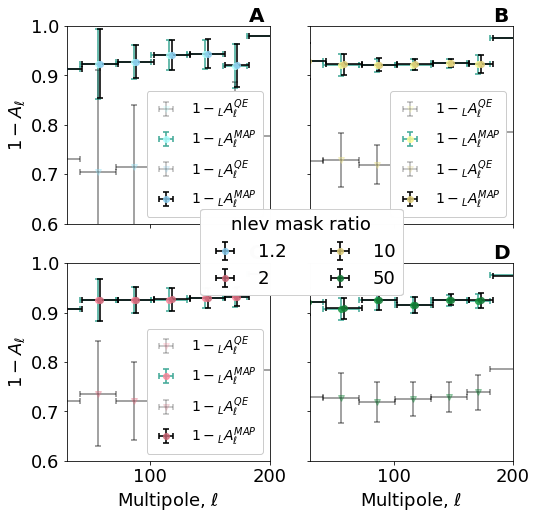

In [16]:
label_f_QE = r'$1-A_\ell^{QE}$'
label_QE_L = r'$1-_{L}A_\ell^{QE}$'
label_QE_C = r'$1-_{C}A_\ell^{QE}$'

label_MAP_L = r'$1-_{L}A_\ell^{MAP}$'
label_MAP_L_mfvar1 = r'$1-_{L}^{m07}A_\ell^{MAP}$'
label_MAP_L_mfvar2 = r'$1-_{L}^{m00}A_\ell^{MAP}$'
label_MAP_C = r'$1-_{C}A_\ell^{MAP}$'

lmax_loc = 256+1
bl = co.edges[:-1]
bu = co.edges[1:]

blu1d = np.array([[l,u] for l,u in zip(bl,bu)]).flatten()
delx = 40
diffx = (bu - bl)/2
xerr = diffx
nrow, ncol = 2,2
i=0.1
import string
fig, ax = plt.subplots(nrow,ncol,figsize=[8, 8], sharex=True, sharey=True)
axs = ax.flat
for n, axx in enumerate(axs): 
    axx.text(0.9, 1.02, string.ascii_uppercase[n], transform=axx.transAxes, 
        size=20, weight='bold')

for dmi, dm in enumerate(dms):
    fg = dm.data.fg
    # fg = dm.data.class_parameters['fg']
    plotlines = []
    plotlines_fg = []
    for nlevi, nlev in enumerate(co.nlevels):
        xshift = -delx/(len(co.nlevels)/2) + i*delx/(len(co.nlevels))
        if dmi == 0:
            col_black = ph.colorscale(colors[11], 1.3)
            col = ph.colorscale(colors[nlevi], 1.3)
        elif dmi == 1: 
            label_QE_L = r'$1-_{L}A_\ell^{QE}$'
            label_MAP_L = r'$1-_{L}A_\ell^{MAP}$'
            col_black = ph.colorscale(colors[11], 1.0)
            col = ph.colorscale(colors[nlevi], 1.0)
        elif dmi == 2:
            col_black = ph.colorscale(colors[11], 0.6)
            col = ph.colorscale(colors[nlevi], 0.6)
        dmicolor = colors[6+dmi]
        if dmi == 1:
            dmicolor = 'black'
        1-(np.mean(bcl_L[dmi,2,nlevi,:],axis=0)/(np.mean(bcl_L[dmi,0,nlevi,:],axis=0)))
        mean, std = ph.get_ms(np.array(1-bcl_L[dmi,1,nlevi,:]), binspace=1)
        ax[nlevi%nrow][int(nlevi/ncol)].errorbar(xshift+co.edges_center, mean, yerr=std, xerr=xerr, mec=col, mfc=col, color='black', label=label_QE_L, alpha=0.2, lw=2, fmt='v', capsize=3, capthick=2, fillstyle='full')
        # print('qe dmi: {}, nlevel: {}, rla: {}'.format(dmi,nlev, mean[:6]))
        mean, std = ph.get_ms(np.array(1-bcl_L[dmi,-1,nlevi,:]), binspace=1)
        l2 = ax[nlevi%nrow][int(nlevi/ncol)].errorbar(dmi*2+xshift+co.edges_center, mean, yerr=std, xerr=xerr, mec=col, mfc=col, color=dmicolor, label=label_MAP_L, alpha=0.8, lw=2, fmt='o', capsize=3, capthick=2, fillstyle='full')
        l3 = ax[nlevi%nrow][int(nlevi/ncol)].errorbar(1, 1, yerr=1, xerr=1, label=None, mec=col_black, mfc=col_black, color='black',  alpha=0.8, lw=2, fmt='o', capsize=3, capthick=2, fillstyle='full')
        # print('dmi: {}, nlevel: {}, rla: {}'.format(dmi,nlev, mean[:6]))
        if nlevi == 0:
            plotlines_fg.append(l3)
        plotlines.append(l2)
#         title="Fg {}".format(co.fg), 
        leg1 = ax[nlevi%nrow][int(nlevi/ncol)].legend(loc='lower right', framealpha=1.0, ncol=1, fontsize=14)
    label_QE_L, label_MAP_L = '',''
    ax[nlevi%nrow][int(nlevi/ncol)].legend(loc='lower right', framealpha=1.0, ncol=2, fontsize=18)
    ax[nlevi%nrow][int(nlevi/ncol)].set_xlim((2,lmax_plot))
    ax[nlevi%nrow][int(nlevi/ncol)].set_ylim((0.6,1))
    
    ax[0][1].set_xlim((30,200))
    ax[1][1].set_xlabel((30,200))
    ax[0][0].set_ylabel(r'$1-A_\ell$', fontsize=18)
    ax[1][0].set_ylabel(r'$1-A_\ell$', fontsize=18)
    ax[1][0].set_xlabel(r'Multipole, $\ell$', fontsize=18)
    ax[1][1].set_xlabel(r'Multipole, $\ell$', fontsize=18)
    # ax[0][1].set_title('Residual lensing amplitude, {} simulations\n'.format(len(co.simids)), x=-0.1)

    leg2 = plt.legend(plotlines, [nlev for nlev in co.nlevels], title='nlev mask ratio', loc=1, ncol=2, bbox_to_anchor=[0.5,1.32])
    # leg3 = plt.legend(plotlines_fg, [f for f in [fg]], title='Fg-model', loc=1, bbox_to_anchor=[0.2,0.5])
    # plt.gca().add_artist(leg3)
    plt.gca().add_artist(leg2)
    # plt.gca().add_artist(leg1)
    if not os.path.exists('/global/homes/s/sebibel/plots/'+co.sims):
        os.makedirs('/global/homes/s/sebibel/plots/'+co.sims)
    plt.savefig('/global/homes/s/sebibel/plots/'+co.sims+'/rla_dlmmod_fg00_allnlev.pdf'.format(fg), bbox_inches='tight')

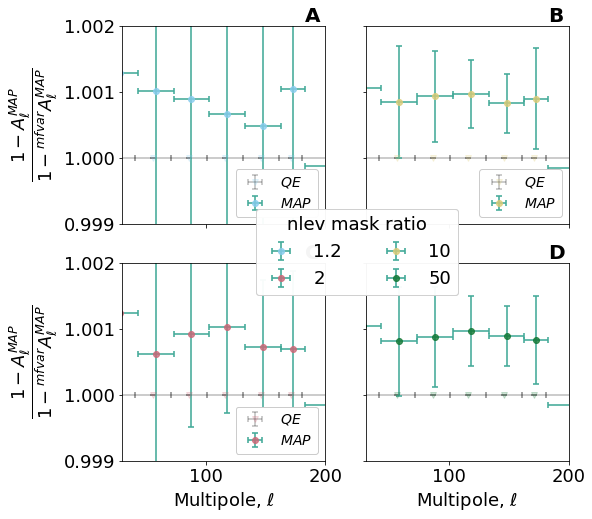

In [19]:
label_f_QE = r'$1-A_\ell^{QE}$'
label_QE_L = r'$1-_{L}A_\ell^{QE}$'
label_QE_C = r'$1-_{C}A_\ell^{QE}$'

label_MAP_L = r'$1-_{L}A_\ell^{MAP}$'
label_MAP_L_mfvar1 = r'$1-_{L}^{m07}A_\ell^{MAP}$'
label_MAP_L_mfvar2 = r'$1-_{L}^{m00}A_\ell^{MAP}$'
label_MAP_C = r'$1-_{C}A_\ell^{MAP}$'

lmax_loc = 256+1
bl = co.edges[:-1]
bu = co.edges[1:]

blu1d = np.array([[l,u] for l,u in zip(bl,bu)]).flatten()
delx = 40
diffx = (bu - bl)/2
xerr = diffx
nrow, ncol = 2,2
i=0.1
import string
fig, ax = plt.subplots(nrow,ncol,figsize=[8, 8], sharex=True, sharey=True)
axs = ax.flat
for n, axx in enumerate(axs): 
    axx.text(0.9, 1.02, string.ascii_uppercase[n], transform=axx.transAxes, 
        size=20, weight='bold')


fg = dms[0].data.fg
# fg = dm.data.class_parameters['fg']
plotlines = []
plotlines_fg = []
for nlevi, nlev in enumerate(co.nlevels):
    xshift = -delx/(len(co.nlevels)/2) + i*delx/(len(co.nlevels))
    if dmi == 0:
        col_black = ph.colorscale(colors[11], 1.3)
        col = ph.colorscale(colors[nlevi], 1.3)
    elif dmi == 1: 
        label_QE_L = r'$QE$'
        label_MAP_L = r'$MAP$'
        col_black = ph.colorscale(colors[11], 1.0)
        col = ph.colorscale(colors[nlevi], 1.0)
    elif dmi == 2:
        col_black = ph.colorscale(colors[11], 0.6)
        col = ph.colorscale(colors[nlevi], 0.6)
    dmicolor = colors[6+0]
    ratio = np.array([(1-bcl_L[0,1,nlevi,simidx])/(1-bcl_L[1,1,nlevi,simidx]) for simidx in range(len(co.simids))])
    mean, std = ph.get_ms(ratio, binspace=1)
    ax[nlevi%nrow][int(nlevi/ncol)].errorbar(xshift+co.edges_center, mean, yerr=std, xerr=xerr, mec=col, mfc=col, color='black', label=label_QE_L, alpha=0.2, lw=2, fmt='v', capsize=3, capthick=2, fillstyle='full')
    ratio = np.array([(1-bcl_L[1,-1,nlevi,simidx])/(1-bcl_L[0,-1,nlevi,simidx]) for simidx in range(len(co.simids))])
    mean, std = ph.get_ms(ratio, binspace=1)
    l2 = ax[nlevi%nrow][int(nlevi/ncol)].errorbar(1*2+xshift+co.edges_center, mean, yerr=std, xerr=xerr, mec=col, mfc=col, color=dmicolor, label=label_MAP_L, alpha=0.8, lw=2, fmt='o', capsize=3, capthick=2, fillstyle='full')
    l3 = ax[nlevi%nrow][int(nlevi/ncol)].errorbar(1, 1, yerr=1, xerr=1, label=None, mec=col_black, mfc=col_black, color='black',  alpha=0.8, lw=2, fmt='o', capsize=3, capthick=2, fillstyle='full')
    # print('dmi: {}, nlevel: {}, rla: {}'.format(dmi,nlev, mean[:6]))
    if nlevi == 0:
        plotlines_fg.append(l3)
    plotlines.append(l2)
#         title="Fg {}".format(co.fg),
    leg1 = ax[nlevi%nrow][int(nlevi/ncol)].legend(loc='lower right', framealpha=1.0, ncol=1, fontsize=14)
label_QE_L, label_MAP_L = '',''
ax[nlevi%nrow][int(nlevi/ncol)].legend(loc='lower right', framealpha=1.0, ncol=2, fontsize=18)
ax[nlevi%nrow][int(nlevi/ncol)].set_xlim((2,lmax_plot))
ax[nlevi%nrow][int(nlevi/ncol)].set_ylim((0.999,1.002))


ax[0][1].set_xlim((30,200))
ax[1][1].set_xlabel((30,200))
ax[0][0].set_ylabel(r'$\dfrac{1-A_\ell^{MAP}}{1-^{mfvar}A_\ell^{MAP}}$', fontsize=18)
ax[1][0].set_ylabel(r'$\dfrac{1-A_\ell^{MAP}}{1-^{mfvar}A_\ell^{MAP}}$', fontsize=18)
ax[1][0].set_xlabel(r'Multipole, $\ell$', fontsize=18)
ax[1][1].set_xlabel(r'Multipole, $\ell$', fontsize=18)
# ax[0][1].set_title('Residual lensing amplitude, {} simulations\n'.format(len(co.simids)), x=-0.1)

leg2 = plt.legend(plotlines, [nlev for nlev in co.nlevels], title='nlev mask ratio', loc=1, ncol=2, bbox_to_anchor=[0.5,1.32])
# leg3 = plt.legend(plotlines_fg, [f for f in [fg]], title='Fg-model', loc=1, bbox_to_anchor=[0.2,0.5])
# plt.gca().add_artist(leg3)
plt.gca().add_artist(leg2)
# plt.gca().add_artist(leg1)
plt.savefig('/global/homes/s/sebibel/plots/'+co.sims+'/rla_dlmmod_ratio_fg00_allnlev.pdf'.format(fg), bbox_inches='tight')

In [ ]:
label_f_QE = r'$1-A_l^{QE}$'
label_QE_L = r'$1-_{L}A_l^{QE}$'
label_QE_C = r'$1-_{C}A_l^{QE}$'

label_MAP_L = r'$1-_{L}A_l^{MAP}$'
label_MAP_C = r'$1-_{C}A_l^{MAP}$'

lmax_loc=256+1
bl = co.edges[:-1]
bu = co.edges[1:]

blu1d = np.array([[l,u] for l,u in zip(bl,bu)]).flatten()
delx = 40
diffx = (bu - bl)/2
xerr = diffx
nrow, ncol = 2,2

for dmi, dm in enumerate(dms):
    fg = dm.data.fg
    # fg = dm.data.class_parameters['fg']
    fig, ax = plt.subplots(nrow,ncol,figsize=[8, 8], sharex=True, sharey=True)
    plotlines = []
    plotlines_fg = []
    i=0.1
    for nlevi, nlev in enumerate(co.nlevels_loc):
        xshift = -delx/(len(co.nlevels)/2) + i*delx/(len(co.nlevels))
        if dmi == 0:
            col_black = colorscale(colors[11], 1.3)
            col = colorscale(colors[nlevi], 1.3)
        elif dmi == 1:
            label_QE_L = r'$1-_{L}A_l^{QE}$'
            label_MAP_L = r'$1-_{L}A_l^{MAP}$'
            col_black = colorscale(colors[11], 1.0)
            col = colorscale(colors[nlevi], 1.0)
        elif dmi == 2:
            col_black = colorscale(colors[11], 0.6)
            col = colorscale(colors[nlevi], 0.6)

        x, mean, std = get_ms(1-np.array([bcl_cs[1,dmi,nlevi,simidx] for simidx in range(len(co.simids))]), binspace=1)
        ax[nlevi%nrow][int(nlevi/ncol)].errorbar(xshift+x, mean, yerr=std, xerr=xerr, mec=col, mfc=col, color='black', label=label_QE_C, alpha=0.2, lw=2, fmt='x', capsize=3, capthick=2, fillstyle='full')

        x, mean, std = get_ms(1-np.array([bcl_cs[-1,dmi,nlevi,simidx] for simidx in range(len(co.simids))]), binspace=1)
        l2 = ax[nlevi%nrow][int(nlevi/ncol)].errorbar(xshift+x, mean, yerr=std, xerr=xerr, mec=col, mfc=col, color='black', label=label_MAP_C, alpha=0.8, lw=2, fmt='o', capsize=3, capthick=2, fillstyle='full')
        l3 = ax[nlevi%nrow][int(nlevi/ncol)].errorbar(1, 1, yerr=1, xerr=1, label=None, mec=col_black, mfc=col_black, color='black',  alpha=0.8, lw=2, fmt='o', capsize=3, capthick=2, fillstyle='full')
        # x, mean, std = get_ms(1-np.array([bcl_L[3,dmi,nlevi,simidx] for simidx in range(len(co.simids))]), binspace=1)
        # ax[nlevi%nrow][int(nlevi/ncol)].errorbar(1.1*xshift+x, mean, yerr=std, xerr=xerr, mec=col, mfc=col, color='purple', label=label_MAP_L, alpha=0.8, lw=2, fmt='o', capsize=3, capthick=2, fillstyle='full')
        if nlevi == 0:
            plotlines_fg.append(l3)
        plotlines.append(l2)
        leg1 = ax[nlevi%nrow][int(nlevi/ncol)].legend(title='foreground {}'.format(fg), loc='lower right', framealpha=1.0, ncol=1, fontsize=14)
    label_QE_L, label_MAP_L = '',''
    ax[nlevi%nrow][int(nlevi/ncol)].legend(loc='lower right', framealpha=1.0, ncol=2, fontsize=18)
    ax[nlevi%nrow][int(nlevi/ncol)].set_xlim((2,lmax_plot))
    ax[nlevi%nrow][int(nlevi/ncol)].set_ylim((0.2,1))
    
    ax[0][1].set_xlim((30,200))
    ax[1][1].set_xlabel((30,200))
    ax[0][0].set_ylabel(r'$1-A_l$', fontsize=18)
    ax[1][0].set_ylabel(r'$1-A_l$', fontsize=18)
    ax[1][0].set_xlabel(r'Multipole, $\ell$', fontsize=18)
    ax[1][1].set_xlabel(r'Multipole, $\ell$', fontsize=18)
    # ax[0][1].set_title('Residual lensing amplitude, {} simulations\n'.format(len(co.simids)), x=-0.1)

    leg2 = plt.legend(plotlines, [nlev for nlev in nlevels_loc], title='nlev mask ratio', loc=1, bbox_to_anchor=[0.35,1.5])
    leg3 = plt.legend(plotlines_fg, [f for f in [fg]], title='Fg-model', loc=1, bbox_to_anchor=[0.2,0.5])
    plt.gca().add_artist(leg3)
    plt.gca().add_artist(leg2)
    # plt.gca().add_artist(leg1)
    plt.savefig('/global/homes/s/sebibel/notebooks/cmbs4/plots/'+co.sims+'/rba_fg{}_allnlev.pdf'.format(fg))

## B amplitude
# ATTENTION
From here on, load ioreco_bins

In [ ]:
for dmi, dm in enumerate(dms):
    fg = dm.data.fg
    # fg = dm.data.class_parameters['fg']
    fig, ax = plt.subplots(figsize=(8,6))
    for nlevi, nlev in enumerate(co.nlevels_loc):
        for simidx in range(len(co.simids)):
            if simidx % 10 == 0:
                plt.errorbar(bcl_cs[dmi,nlevi,simidx,1], 2*nlevi+1-0.3, capsize=0, lw=3, capthick=0, color=colors[nlevi], fmt='o', markersize=6, alpha=0.1)
                plt.errorbar(bcl_cs[dmi,nlevi,simidx,1], 2*nlevi-0.3, capsize=0, lw=3, capthick=0, color=colors[nlevi], fmt='o', markersize=6, alpha=0.3)

        m_QE, s_QE = np.mean(bcl_cs[dmi,nlevi,:,1]), np.std(bcl_cs[dmi,nlevi,:,1])
        plt.errorbar(m_QE, 2*nlevi+1, xerr=s_QE, capsize=5, label='{}'.format(nlev), lw=2, capthick=3, color=colors[nlevi], fmt='o', markersize=8, alpha=0.3)
        plt.text(m_QE, 2*nlevi+1+0.15, r'%.2f$\pm$%.2f'%(m_QE, s_QE), fontsize=10)

        m_MAP, s_MAP = np.mean(bcl_cs[dmi,nlevi,:,1]), np.std(bcl_cs[dmi,nlevi,:,1])
        plt.errorbar(m_MAP, 2*nlevi, xerr=s_MAP, capsize=5, label='{}'.format(nlev), lw=3, capthick=3, color=colors[nlevi], fmt='o', markersize=8)
        plt.text(m_MAP, 2*nlevi+0.15, r'%.2f$\pm$%.2f'%(m_MAP, s_MAP), fontsize=14)
    # for nlevi, nlev in enumerate(co.nlevels):

    plt.xlabel('Residual B power after delensing', fontsize=12)
    h, l = ax.get_legend_handles_labels()
    ph = [plt.plot([],marker="", ls="")[0]]*2
    handles = ph[1:] + h[1::2][::-1] + ph[:1] + h[::2][::-1]
    labels = ["MAP, mask ratio:"] + l[1::2][::-1] + ["QE, mask ratio:"] + l[::2][::-1]
    leg = plt.legend(handles, labels, ncol=2)
    
    plt.title('Fg-model {}. Residual B power after delensing.'.format(fg), fontsize=12)
    # plt.xlim((0.21,0.435))
    # plt.ylim((0.5,4.5))
    # plt.yticklabels([])
    ax = plt.gca()
    ax.yaxis.set_visible(False)
    plt.savefig('/global/homes/s/sebibel/notebooks/cmbs4/plots/'+co.sims+'/residual_bpower_fg{}.pdf'.format(fg))

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(8,6), sharex=True, sharey= True)
# nlevels_loc = np.take(co.nlevels,np.array([0,3,5,7]))
nlevi_loc = [0,1,2,3]
nlevels_loc = np.take(co.nlevels,np.array(nlevi_loc))
xshift_QE_text = 0.1
xshift_MAP_text = 0.0
for dmi, dm in enumerate(dms):
    fg = dm.data.fg
    # fg = dm.data.class_parameters['fg']
    for nlevi, nlev in enumerate(co.nlevels_loc):
        if fgi == 0:
            col = colorscale(colors[nlevi], 1.3)
        elif fgi == 1:
            col = colorscale(colors[nlevi], 1.0)
        elif fgi == 2:
            col = colorscale(colors[nlevi], 0.6)
            
        for simidx in range(len(co.simids)):
            if simidx%10 == 0:
                ax[fgi].errorbar(bcl_L[1,fgi,nlevi,simidx,1], 2*nlevi+1-0.3, capsize=0, lw=3, capthick=0, color=col, fmt='x', markersize=6, alpha=0.2)
                ax[fgi].errorbar(bcl_L[2,fgi,nlevi,simidx,1], 2*nlevi-0.3, capsize=0, lw=3, capthick=0, color=col, fmt='o', markersize=6, alpha=0.08)
        m_QE, s_QE = np.mean(bcl_L[1,fgi,nlevi,:,1]), np.std(bcl_L[1,fgi,nlevi,:,1])
        ax[fgi].errorbar(m_QE, 2*nlevi+1, xerr=s_QE, capsize=5, label='{}'.format(nlev), lw=2, capthick=3, color=col, fmt='x', markersize=8, alpha=0.8)
        ax[fgi].text(m_QE-xshift_QE_text, 2*nlevi+1+0.15, r'%.3f$\pm$%.3f'%(m_QE, s_QE), fontsize=10)
        
        m_MAP, s_MAP = np.mean(bcl_L[-1,fgi,nlevi,:,1]), np.std(bcl_L[-1,fgi,nlevi,:,1])
        ax[fgi].errorbar(m_MAP, 2*nlevi, xerr=s_MAP, capsize=5, label='{}'.format(nlev), lw=3, capthick=3, color=col, fmt='o', markersize=8)
        ax[fgi].text(m_MAP+xshift_MAP_text, 2*nlevi+0.15, r'%.3f$\pm$%.3f'%(m_MAP, s_MAP), fontsize=14)
        print(r'%.4f$\pm$%.4f'%(m_MAP, s_MAP))

    # ax[fgi].set_xlabel('Res. B-lens amplitude', fontsize=12)
    ax[fgi].set_title('Fg-model {}'.format(fg), fontsize=12)
    ax[fgi].yaxis.set_visible(False)
    ax[fgi].set_xlim((0.05,0.35))
    ax[fgi].set_ylim((-0.5,2*len(co.nlevels_loc)-0.5))

h, l = ax[1].get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]*2
handles = ph[1:] + h[1::2][::-1] + ph[:1] + h[::2][::-1]
labels = ["MAP, mask ratio:"] + l[1::2][::-1] + ["QE, mask ratio:"] + l[::2][::-1]
leg = plt.legend(handles, labels, ncol=2, bbox_to_anchor=[1.05, 1.55], framealpha=1)
    # plt.xlim((0.21,0.435))
    # plt.ylim((0.5,4.5))
    # plt.yticklabels([])
ax = plt.gca()
ax.text(-0.72,3, 'B-lensing', rotation=90)
# ax.yaxis.set_visible(False)
plt.savefig('/global/homes/s/sebibel/notebooks/cmbs4/plots/'+co.sims+'/residual_lensing_amplitude_allfg.pdf'.format(fg), bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(8,6), sharex=True, sharey= True)
xshift_QE_text = +0.2
xshift_MAP_text = -0.25
for dmi, dm in enumerate(dms):
    fg = dm.data.fg
    # fg = dm.data.class_parameters['fg']
    for nlevi, nlev in enumerate(co.nlevels_loc):
        if fgi == 0:
            col = colorscale(colors[nlevi], 1.3)    
        elif fgi == 1:
            col = colorscale(colors[nlevi], 1.0)

        elif fgi == 2:
            col = colorscale(colors[nlevi], 0.6)           
        for simidx in range(len(co.simids)):
            if simidx%10 == 0:
                ax[fgi].errorbar(bcl_cs[1,fgi,nlevi,simidx,1]/bcl_cs[0,fgi,nlevi,simidx,1], 2*nlevi+1-0.3, capsize=0, lw=3, capthick=0, color=col, fmt='x', markersize=6, alpha=0.2)
                ax[fgi].errorbar(bcl_cs[-1,fgi,nlevi,simidx,1]/bcl_cs[0,fgi,nlevi,simidx,1], 2*nlevi-0.3, capsize=0, lw=3, capthick=0, color=col, fmt='o', markersize=6, alpha=0.08)

        m_QE, s_QE = np.mean(bcl_cs[1,fgi,nlevi,:,1]/bcl_cs[0,fgi,nlevi,:,1]), np.std(bcl_cs[1,fgi,nlevi,:,1]/bcl_cs[0,fgi,nlevi,:,1])
        ax[fgi].errorbar(m_QE, 2*nlevi+1, xerr=s_QE, capsize=5, label='{}'.format(nlev), lw=2, capthick=3, color=col, fmt='x', markersize=8, alpha=0.8)
        ax[fgi].text(m_QE-xshift_QE_text, 2*nlevi+1+0.15, r'%.2f$\pm$%.2f'%(m_QE, s_QE), fontsize=10)
        
        m_MAP, s_MAP = np.mean(bcl_cs[-1,fgi,nlevi,:,1]/bcl_cs[0,fgi,nlevi,:,1]), np.std(bcl_cs[-1,fgi,nlevi,:,1]/bcl_cs[0,fgi,nlevi,:,1])
        ax[fgi].errorbar(m_MAP, 2*nlevi, xerr=s_MAP, capsize=5, label='{}'.format(nlev), lw=3, capthick=3, color=col, fmt='o', markersize=8)
        ax[fgi].text(m_MAP+xshift_MAP_text, 2*nlevi+0.15, r'%.2f$\pm$%.2f'%(m_MAP, s_MAP), fontsize=14)

    ax[fgi].set_xlabel('Res. B amplitude', fontsize=12)
    # ax[fgi].set_title('Fg-model {}.'.format(fg), fontsize=12)
    ax[fgi].yaxis.set_visible(False)
    ax[fgi].set_ylim((-0.5,2*len(co.nlevels_loc)-0.5))
    
h, l = ax[0].get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]*2
handles = ph[1:] + h[1::2][::-1] + ph[:1] + h[::2][::-1]
labels = ["MAP, mask ratio:"] + l[1::2][::-1] + ["QE, mask ratio:"] + l[::2][::-1]

# leg = plt.legend(handles, labels, ncol=2, bbox_to_anchor=[0.2, 1.5], framealpha=1)
plt.xlim((0.11,0.535))
# plt.ylim((0.5,4.5))
# plt.yticklabels([])
ax = plt.gca()
ax.text(-0.45,3, 'B-power', rotation=90)
# plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/residual_ILCB-amplitude_allfg.pdf'.format(fg), bbox_inches='tight')

## Other

# Old

In [ ]:
label_fQE = r'$_{L}B - \hat{B}^{QE}$'
label_fMAP = r'$_{L}B - \hat{B}^{MAP}$'
label_csQE = r'$_{C}B - \hat{B}^{QE}$'
label_csMAP = r'$_{C}B - \hat{B}^{MAP}$'

label_f = r'$_{{L}}C_l$'
label_cs = r'$_{{C}}C_l$'

label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
cmap = matplotlib.cm.get_cmap('Paired')
colors2 = np.array([cmap(nlevi/(6*len(co.simids))) for nlevi in range(6*len(co.simids))])
binspace=1

def plot_content(a, bcl_cs_jm, bcl_L_jm, bcl_Llensc_QE_jm, bcl_cslensc_QE_jm, 
                 bcl_Llensc_MAP_jm, bcl_cslensc_MAP_jm, baseBmap, nlevi, fgi, color=''):
    ms = 10
    alpha = 1.#(nlevi+1)/(len(co.nlevels_loc)+1)
    if color =='':
        label_suffix = ''
        if fgi == 0:
            col = colorscale(colors[nlevi], 1.3)
        elif fgi == 1:
            col = colorscale(colors[nlevi], 1.0)
        elif fgi == 2:
            col = colorscale(colors[nlevi], 0.6)
    else:
        col = 'grey'
        label_suffix = ' mf-sub'
    if baseBmap == 'L':
        '''
        Pure B-lensing
        '''
        c1, c2 = 10, 7
        c3, c4 = 0, 2             
        x, mean, std = get_ms(bcl_L_jm*co.ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, 
         label=label_f, color='black', alpha=0.4, edgecolor='black')
        a.plot(x, mean, color='black', alpha=0.6, lw=1)

        x, mean, std = get_ms(bcl_Llensc_QE_jm*co.ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap)+label_suffix, color=col, alpha=0.3, edgecolor='black')
        a.plot(x, mean, color='grey', alpha=0.3, lw=1)
        
        x, mean, std = get_ms(bcl_Llensc_MAP_jm*co.ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap)+label_suffix, color=col, alpha=0.6, edgecolor='black')
        a.plot(x, mean, color='grey', alpha=0.8, lw=1)


    elif baseBmap == 'C':
        '''
        Component separation
        ''' 
        c1, c2 = 10, 7
        c3, c4 = 0, 2
        
        if color =='':
            x, mean, std = get_ms(bcl_cs_jm*co.ct, binspace=binspace)
            a.fill_between(x, mean+std, mean-std, label=label_cs, color='black', alpha=0.4, edgecolor='black')
            a.plot(x, mean, color='black', alpha=0.6, lw=1)
            # a.plot(x, mean, color='red', alpha=alpha, lw=1)
        
        x, mean, std = get_ms(bcl_cslensc_QE_jm*co.ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_QE.format(baseBmap)+label_suffix, color=col, alpha=0.3, edgecolor='black')
        a.plot(x, mean, color='grey', alpha=0.3, lw=1)
        # a.plot(x, mean, color='purple', alpha=alpha, lw=1)

        x, mean, std = get_ms(bcl_cslensc_MAP_jm*co.ct, binspace=binspace)
        a.fill_between(x, mean+std, mean-std, label=label_MAP.format(baseBmap)+label_suffix, color=col, alpha=0.6, edgecolor='black')
        a.plot(x, mean, color='grey', alpha=0.8, lw=1)
        # a.plot(x, mean, color='yellow', alpha=alpha, lw=1)
for dmi, dm in enumerate(dms):
    fg = dm.data.fg
    # fg = dm.data.class_parameters['fg']
    fig, ax = plt.subplots(4, 2, figsize=[16,24])
    for bBi, bB in enumerate(['L', 'C']):
        label_f = r'$_{{L}}C_l$'
        label_cs = r'$_{{C}}C_l$'
        label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
        label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
        for nlevi, nlev in enumerate(co.nlevels_loc):
        # for nlevi, nlev in enumerate([nlevels[7]]):#['cmbs4', 'julien']:
            # nlevi=7
            baseBmap = bB
            label_f = None
            label_QE = ''
            label_MAP = ''
            label_cs = ''
            if True:#nlevi == len(co.nlevels[-2:]) - 1:
                label_f = r'$_{{L}}C_l$'
                label_cs = r'$_{{C}}C_l$'
                label_QE = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,QE,del}}$'
                label_MAP = r'$_{{{}}}\hat{{C}}_{{l}}^{{BB,MAP,del}}$'
            plot_content(
                ax[nlevi,bBi],
                bcl_cs[fgi,nlevi], bcl_L[fgi,nlevi],
                baseBmap, nlevi, fgi)
 
            ax[nlevi][bBi].set_xlim((37.,lmax_plot))
            ax[nlevi][bBi].set_ylim((0.0e-6,4e-6))       
            if baseBmap == 'L':
                if nlevi == 0:
                    ax[nlevi,bBi].set_title('$f_{{{}}}$.'.format(fg, len(co.simids)) + ' Remaining \n B-lensing @ noise-level-mask ratio \n{} '.format(nlev))
                else:
                    ax[nlevi,bBi].set_title('{}'.format(nlev))
                ax[nlevi,bBi].legend(title=r'$_{{{}}}C=$ B-lensing'.format(baseBmap), loc='upper right', framealpha=1.0)
            else:
                if nlevi == 0:
                    ax[nlevi,bBi].set_title('$f_{{{}}}$.'.format(fg, len(co.simids)) + ' Remaining \n B-power @ noise-level-mask ratio \n{}'.format(nlev))
                else:
                    ax[nlevi,bBi].set_title('{}'.format(nlev))
                ax[nlevi,bBi].legend(title=r'$_{{{}}}C=$ ILC-map'.format(baseBmap), loc='upper right', framealpha=1.0)

            if nlevi == len(co.nlevels_loc)-1:
                ax[nlevi,bBi].set_xlabel(r'Multipole $\ell$', fontsize=22)
            if bBi == 0:
                ax[nlevi,bBi].set_ylabel(r'$C_l$ [$\mu K^2$]', fontsize=22)
    plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/ClBB_ens_avg_fg{}_allnlev.pdf'.format(fg))
    plt.show()